In [ ]:
# Should be first to load all the env vars for browser
import os
from dotenv import load_dotenv

load_dotenv()

assert os.getenv("CHROME_USER_DATA_DIR", None)

In [1]:
from typing import TypedDict

from generalist.agents.core import AgentPlan
from generalist.tools.data_model import ContentResource, ShortAnswer, Task

class ExecutionState(TypedDict):
    # what user is asking to do for them 
    ask: str
    # Identifies what the original question/task given, which objective it got transferred to, what the plan to get an answer is
    task: Task
    # order index of the step of the task's plan that is being executed 
    step: int
    # Clues, findings and answers to the previous subtasks
    # Used to execute a capability plan step given already found information
    context: str  
    # capability plan for this task (overwritten when a new subtask from the main plain is picked up)
    capability_plan: AgentPlan
    # capability plan step order 
    capability_plan_step: int
    # answers to subtask, the last one should be the final answer to the task 
    answers: list[ShortAnswer]
    # all text resources that might be needed to execute the task
    resources: list[ContentResource]
    # tools that already got called
    # TODO: see if this is needed 
    tools_called: str

/Users/maksim.rostov/pdev/freelectron/free-generalist/.venv/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'validate_default' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'validate_default' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(


In [2]:
MAX_STEPS = 2


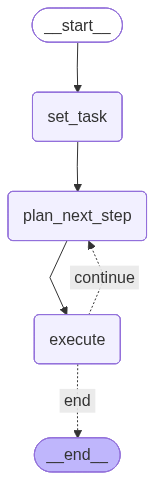

In [3]:
import json
from generalist.agents.core import AgentDeepWebSearch, AgentUnstructuredDataProcessor, \
    AgentCodeWriterExecutor, AgentAudioProcessor, AgentOutput
from generalist.tools.planning import determine_capabilities, create_plan
from generalist.tools.summarisers import construct_short_answer
from langgraph.graph import StateGraph, START, END


def init_state(ask: str, resources: list[ContentResource] | None = None) -> ExecutionState:
    return ExecutionState(
        ask=ask,
        task=None,
        step=None,
        context="",
        answers=list(),
        resources=resources if resources else [],
    )

def set_task(state: ExecutionState) -> ExecutionState:
    question_task = state["ask"]
    task_plan_response = create_plan(question_task)

    result = json.loads(task_plan_response)
    task = Task(
      question=question_task,
      objective=result["objective"],
      plan=result["plan"],
    )
    identified_resource = result.get("resource", None)
    if identified_resource:
        task_resource = ContentResource(
            provided_by="user",
            content=identified_resource.get("content", None),
            link=identified_resource.get("link", None),
            metadata={},
        )
        state["resources"].append(task_resource)
    state["task"] = task

    state["step"] = 0
    return state

def evaluate_task_completion(state: ExecutionState) -> str:
    short_answer = construct_short_answer(
        state["task"].objective,
        state["context"]
    )

    # Early stopping if answer exists
    if short_answer.answered:
        return "end"

    # Early stopping if maximum number of steps reached
    if state['step'] >= MAX_STEPS:
        return "end"

    return "continue"

def plan_next_step(state: ExecutionState) -> ExecutionState:
    # Automatically determine which step to execute based on context
    capability_plan_json = determine_capabilities(
        task=state["task"],
        context=state["context"]
    )

    state["capability_plan"] = AgentPlan.from_json(capability_plan_json)
    return state

def execute(state: ExecutionState) -> ExecutionState:
    activity, capability = state["capability_plan"].subplan[0]
    output = AgentOutput(activity)
    capability_agent = capability(activity)
    if capability is AgentDeepWebSearch:
        # Reinitiate the agent since it might need browser
        capability_agent = capability(activity=activity)
        output = capability_agent.run()
    elif capability is AgentUnstructuredDataProcessor:
        output = capability_agent.run(state["resources"])
    elif capability is AgentCodeWriterExecutor:
        output = capability_agent.run(state["resources"])
    elif capability is AgentAudioProcessor:
        output = capability_agent.run(state["resources"])
    else:
        print("DEBUG | run_capability | Call to unidentified agent: ", capability)

    if output.answers:
        state["answers"].extend(output.answers)
    if output.resources:
        state["resources"].extend(output.resources)

    # Update context with step results
    state["context"] += f"\nStep {state['step']}: {state['answers']}"
    state["step"] += 1

    return state


workflow = StateGraph(state_schema=ExecutionState)

workflow.add_node("set_task", set_task)
workflow.add_node("plan_next_step", plan_next_step)
workflow.add_node("execute", execute)

workflow.add_edge(START, "set_task")
workflow.add_edge("set_task", "plan_next_step")
workflow.add_edge("plan_next_step", "execute")
workflow.add_conditional_edges(
    "execute",
    evaluate_task_completion,
    {
        "continue": "plan_next_step",
        "end": END,
    }
)

generalist_graph = workflow.compile()

from IPython.display import Image, display
display(Image(generalist_graph.get_graph().draw_mermaid_png()))

In [5]:
import os
import logging
from dotenv import load_dotenv

import mlflow
from huggingface_hub import snapshot_download
from datasets import load_dataset


logging.getLogger().setLevel(logging.INFO)
load_dotenv()


gaia_path = os.environ.get("HUGGING_FACE_GAIA_FOLDER_PATH")
data_dir = snapshot_download(local_dir=gaia_path,  local_files_only=True, repo_id="gaia-benchmark/GAIA", repo_type="dataset")

dataset = load_dataset(data_dir, "2023_level1", split="validation")
gaia_keys = ['task_id', 'Question', 'Level', 'Final answer', 'file_name', 'file_path', 'Annotator Metadata']

sosa_many_studio_albums_task_id = "8e867cd7-cff9-4e6c-867a-ff5ddc2550be"
running_to_the_moon_task_id = "e1fc63a2-da7a-432f-be78-7c4a95598703"
dr_who_season_9_eps_11_location_task_id = "4b6bb5f7-f634-410e-815d-e673ab7f8632"
calc_sales_xlsx_task_id = "7bd855d8-463d-4ed5-93ca-5fe35145f733"
just_running_python_task_id = "f918266a-b3e0-4914-865d-4faa564f1aef"
evaluation_tasks = [
    # just_running_python_task_id,
    # calc_sales_xlsx_task_id,
    sosa_many_studio_albums_task_id,
    # running_to_the_moon_task_id,
]

results = []
dataset_questions = { sample["task_id"]:sample for sample in dataset }
for sample_task_id in evaluation_tasks:
    sample = dataset_questions[sample_task_id]
    [ print(k, "=", sample[k]) for k in gaia_keys]

    mlflow.langchain.autolog()                                                     # this is needed to register traces within the experiment
    experiment_name = f"gaia_{"_".join(sample["task_id"].split("-"))}"
    mlflow.set_experiment(experiment_name)
    mlflow.models.set_model(generalist_graph)
    logging.getLogger().setLevel(logging.INFO)

    experiment_url = mlflow.get_experiment_by_name(experiment_name)
    # mlflow.set_tracking_uri('http://localhost:5000')

    question = sample["Question"]
    resources = []
    if sample["file_path"]:
        resource = ContentResource(
            provided_by="user",
            content="file provided with the main task",
            link=os.path.join(os.environ.get("HUGGING_FACE_GAIA_FOLDER_PATH"), sample["file_path"]),
            metadata={"note":"the file is already in the list of available resources"}
        )
        print(resource.link)
        resources.append(resource)
    initial_state = init_state(question, resources=resources)
    final_state = generalist_graph.invoke(initial_state)
    answers = final_state["answers"]
    results.append((sample, {"answers":answers, "experiment_url": experiment_url}))

Returning existing local_dir `/Users/maksim.rostov/pdev/freelectron/free-generalist/evaluation/gaia` as remote repo cannot be accessed in `snapshot_download` (None).


task_id = 8e867cd7-cff9-4e6c-867a-ff5ddc2550be
Question = How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.
Level = 1
Final answer = 3
file_name = 
file_path = 
Annotator Metadata = {'Steps': '1. I did a search for Mercedes Sosa\n2. I went to the Wikipedia page for her\n3. I scrolled down to "Studio albums"\n4. I counted the ones between 2000 and 2009', 'Number of steps': '4', 'How long did this take?': '5 minutes', 'Tools': '1. web browser\n2. google search', 'Number of tools': '2'}


2026-01-23 18:28:24,529 - generalist.tools.planning - determine_capabilities:187 - INFO - Raw output: {
  "subplan": [
    {
      "activity": "Navigate to the Wikipedia page for Mercedes Sosa and locate her discography section, focusing on albums published between 2000 and 2009.",
      "capability": "deep_web_search"
    }
  ]
}
2026-01-23 18:28:34,117 - generalist.tools.web_search - web_search:266 - INFO - Generated queries: ['Mercedes Sosa discography 2000-2009albums']
2026-01-23 18:28:38,065 - generalist.tools.web_search - web_search:274 - INFO - Found 1 unique sources.
[WebSearchResult(link='https://www.discogs.com/artist/333361-Mercedes-Sosa', metadata={'search_order': 0, 'web_page_title': 'Mercedes Sosa Discography: Vinyl, CDs, & More | Discogs', 'web_page_summary': 'N/A', 'query': 'Mercedes Sosa discography 2000-2009albums'})]
2026-01-23 18:28:38,726 - generalist.agents.agent_workflow - process_tool_output:108 - INFO - Wrote web_search to a file /var/folders/f6/6mkw37fs20q07p9

KeyboardInterrupt: 

In [ ]:
# print(
#     """=== Exploratory Data Analysis for 7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx ===\nShape: 9 rows x 7 columns\n--- Column Information ---\nColumns: ['Location', 'Burgers', 'Hot Dogs', 'Salads', 'Fries', 'Ice Cream', 'Soda']\n--- Data Types ---\nLocation     object\nBurgers       int64\nHot Dogs      int64\nSalads        int64\nFries         int64\nIce Cream     int64\nSoda          int64\ndtype: object\n--- Summary Statistics ---\nColumn: Location\n  nans: 0 | count: 9\n  mean: None | min: Algrimand | max: Wharvton\nColumn: Burgers\n  nans: 0 | count: 9\n  mean: 1952.3333333333333 | min: 1594 | max: 2019\nColumn: Hot Dogs\n  nans: 0 | count: 9\n  mean: 2000.3333333333333 | min: 1969 | max: 2022\nColumn: Salads\n  nans: 0 | count: 9\n  mean: 2006.0 | min: 1982 | max: 2022\nColumn: Fries\n  nans: 0 | count: 9\n  mean: 2005.5555555555557 | min: 1989 | max: 2023\nColumn: Ice Cream\n  nans: 0 | count: 9\n  mean: 2003.111111111111 | min: 1969 | max: 2021\nColumn: Soda\n  nans: 0 | count: 9\n  mean: 2116.4444444444443 | min: 1980 | max: 2967\n--- Missing Values ---\nNo missing values found"""
# )

In [ ]:
# import pandas as pd
#
# file_path = '/Users/maksim.rostov/pdev/freeelectron/free-generalist/evaluation/gaia/2023/validation/7bd855d8-463d-4ed5-93ca-5fe35145f733.xlsx'
#
# try:
#     df = pd.read_excel(file_path)
#
#     # Define food item columns excluding drinks
#     food_item_columns = ['Burgers', 'Hot Dogs', 'Salads', 'Fries']
#
#     # Sum up the sales of food items
#     total_food_sales = df[food_item_columns].sum().sum()
#
#     print(f'Total sales for food items (excluding drinks): {total_food_sales}')
# except Exception as e:
#     print(f"An error occurred: {e}")